In [1]:
import os, glob, time, datetime
import numpy as np
from PIL import Image
import imageio
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import torch.nn as nn
from torchvision.utils import save_image

from common.dataset import TrainDataProvider, save_fixed_sample
from common.function import init_embedding
from common.models import Encoder, Decoder, Discriminator, Generator
from common.utils import denorm_image
from common.utils import centering_image
from common.train import Trainer

## Parameter Freezing
- 150epoch 가 pre-trained 된 모델을 이용해서 손글씨를 적은 데이터로 학습시킨다


- 이때, Decoder도 앞부분은 freeze시키면 어떨까? 많이 학습이 되어있는 상태인데 굳이 안 시킬 필요 없을거같아

### 150epoch trained model

In [2]:
GPU = torch.cuda.is_available()
GPU

True

In [3]:
FONTS_NUM = 25
EMBEDDING_NUM = 100
BATCH_SIZE = 18
IMG_SIZE = 128
EMBEDDING_DIM = 128

from_model_path = './model_checkpoint/'
data_dir = './interpolation/dataset/'
fixed_dir = './fixed_sample/'

In [4]:
En = Encoder().cuda()
De = Decoder().cuda()
D = Discriminator(category_num=FONTS_NUM).cuda()

In [5]:
restore = ['150-0604-10:42-Encoder.pkl', '150-0604-10:42-Decoder.pkl', '150-0604-10:42-Discriminator.pkl']

encoder_path, decoder_path, discriminator_path = restore
prev_epoch = int(encoder_path.split('-')[0])
En.load_state_dict(torch.load(os.path.join(from_model_path, encoder_path)))
De.load_state_dict(torch.load(os.path.join(from_model_path, decoder_path)))
D.load_state_dict(torch.load(os.path.join(from_model_path, discriminator_path)))
print("%d epoch trained model has restored" % prev_epoch)

150 epoch trained model has restored


## Parameter 개수 확인

### Encoder

In [6]:
all_param_num = 0
print('name\t\t\t param_num\t Trainable\t size')
print('======================================================================================')
for name, param in En.named_parameters():
    param_num = 1
    for i in param.data.shape:
        param_num *= i
    all_param_num += param_num
    print('%-15s' % name, '\t', '%8s' % str(param_num), '\t', param.requires_grad, '\t\t', param.data.shape)
print('======================================================================================')
print('all paramter number: ', all_param_num)

name			 param_num	 Trainable	 size
conv1.0.weight  	     1600 	 True 		 torch.Size([64, 1, 5, 5])
conv1.0.bias    	       64 	 True 		 torch.Size([64])
conv2.1.weight  	   204800 	 True 		 torch.Size([128, 64, 5, 5])
conv2.1.bias    	      128 	 True 		 torch.Size([128])
conv2.2.weight  	      128 	 True 		 torch.Size([128])
conv2.2.bias    	      128 	 True 		 torch.Size([128])
conv3.1.weight  	   524288 	 True 		 torch.Size([256, 128, 4, 4])
conv3.1.bias    	      256 	 True 		 torch.Size([256])
conv3.2.weight  	      256 	 True 		 torch.Size([256])
conv3.2.bias    	      256 	 True 		 torch.Size([256])
conv4.1.weight  	  1179648 	 True 		 torch.Size([512, 256, 3, 3])
conv4.1.bias    	      512 	 True 		 torch.Size([512])
conv4.2.weight  	      512 	 True 		 torch.Size([512])
conv4.2.bias    	      512 	 True 		 torch.Size([512])
conv5.1.weight  	  2359296 	 True 		 torch.Size([512, 512, 3, 3])
conv5.1.bias    	      512 	 True 		 torch.Size([512])
conv5.2.weight  	      512 	 True 	

### Decoder

In [7]:
all_param_num = 0
print('name\t\t\t param_num\t Trainable\t size')
print('======================================================================================')
for name, param in De.named_parameters():
    param_num = 1
    for i in param.data.shape:
        param_num *= i
    all_param_num += param_num
    print('%-15s' % name, '\t', '%8s' % str(param_num), '\t', param.requires_grad, '\t\t', param.data.shape)
print('======================================================================================')
print('all paramter number: ', all_param_num)

name			 param_num	 Trainable	 size
deconv1.1.weight 	  2949120 	 True 		 torch.Size([640, 512, 3, 3])
deconv1.1.bias  	      512 	 True 		 torch.Size([512])
deconv1.2.weight 	      512 	 True 		 torch.Size([512])
deconv1.2.bias  	      512 	 True 		 torch.Size([512])
deconv2.1.weight 	  8388608 	 True 		 torch.Size([1024, 512, 4, 4])
deconv2.1.bias  	      512 	 True 		 torch.Size([512])
deconv2.2.weight 	      512 	 True 		 torch.Size([512])
deconv2.2.bias  	      512 	 True 		 torch.Size([512])
deconv3.1.weight 	 13107200 	 True 		 torch.Size([1024, 512, 5, 5])
deconv3.1.bias  	      512 	 True 		 torch.Size([512])
deconv3.2.weight 	      512 	 True 		 torch.Size([512])
deconv3.2.bias  	      512 	 True 		 torch.Size([512])
deconv4.1.weight 	  8388608 	 True 		 torch.Size([1024, 512, 4, 4])
deconv4.1.bias  	      512 	 True 		 torch.Size([512])
deconv4.2.weight 	      512 	 True 		 torch.Size([512])
deconv4.2.bias  	      512 	 True 		 torch.Size([512])
deconv5.1.weight 	  4194304 	 

### Discriminator

In [8]:
all_param_num = 0
print('name\t\t\t param_num\t Trainable\t size')
print('======================================================================================')
for name, param in D.named_parameters():
    param_num = 1
    for i in param.data.shape:
        param_num *= i
    all_param_num += param_num
    print('%-15s' % name, '\t', '%8s' % str(param_num), '\t', param.requires_grad, '\t\t', param.data.shape)
print('======================================================================================')
print('all paramter number: ', all_param_num)

name			 param_num	 Trainable	 size
conv1.1.weight  	     1152 	 True 		 torch.Size([64, 2, 3, 3])
conv1.1.bias    	       64 	 True 		 torch.Size([64])
conv2.1.weight  	    73728 	 True 		 torch.Size([128, 64, 3, 3])
conv2.1.bias    	      128 	 True 		 torch.Size([128])
conv2.2.weight  	      128 	 True 		 torch.Size([128])
conv2.2.bias    	      128 	 True 		 torch.Size([128])
conv3.1.weight  	   294912 	 True 		 torch.Size([256, 128, 3, 3])
conv3.1.bias    	      256 	 True 		 torch.Size([256])
conv3.2.weight  	      256 	 True 		 torch.Size([256])
conv3.2.bias    	      256 	 True 		 torch.Size([256])
conv4.1.weight  	  1179648 	 True 		 torch.Size([512, 256, 3, 3])
conv4.1.bias    	      512 	 True 		 torch.Size([512])
conv4.2.weight  	      512 	 True 		 torch.Size([512])
conv4.2.bias    	      512 	 True 		 torch.Size([512])
fc1.weight      	    32768 	 True 		 torch.Size([1, 32768])
fc1.bias        	        1 	 True 		 torch.Size([1])
fc2.weight      	   819200 	 True 		 torch.

#### Encoder + Decoder + Discriminator 파라미터 개수

In [9]:
11356416 + 38348097 + 2404186

52108699

### Decoder은 freeze일 때 deconv5까지 freeze시킨다

In [10]:
all_param_num = 0
freeze_layers = ['deconv1', 'deconv2']

print('name\t\t\t param_num\t Trainable\t size')
print('======================================================================================')
for name, param in De.named_parameters():
    param_num = 1
    for i in param.data.shape:
        param_num *= i
    all_param_num += param_num
    
    # freeze
    if name.split('.')[0] in freeze_layers:
        param.requires_grad = False
        
    print('%-15s' % name, '\t', '%8s' % str(param_num), '\t', param.requires_grad, '\t\t', param.data.shape)
print('======================================================================================')
print('all paramter number: ', all_param_num)

name			 param_num	 Trainable	 size
deconv1.1.weight 	  2949120 	 False 		 torch.Size([640, 512, 3, 3])
deconv1.1.bias  	      512 	 False 		 torch.Size([512])
deconv1.2.weight 	      512 	 False 		 torch.Size([512])
deconv1.2.bias  	      512 	 False 		 torch.Size([512])
deconv2.1.weight 	  8388608 	 False 		 torch.Size([1024, 512, 4, 4])
deconv2.1.bias  	      512 	 False 		 torch.Size([512])
deconv2.2.weight 	      512 	 False 		 torch.Size([512])
deconv2.2.bias  	      512 	 False 		 torch.Size([512])
deconv3.1.weight 	 13107200 	 True 		 torch.Size([1024, 512, 5, 5])
deconv3.1.bias  	      512 	 True 		 torch.Size([512])
deconv3.2.weight 	      512 	 True 		 torch.Size([512])
deconv3.2.bias  	      512 	 True 		 torch.Size([512])
deconv4.1.weight 	  8388608 	 True 		 torch.Size([1024, 512, 4, 4])
deconv4.1.bias  	      512 	 True 		 torch.Size([512])
deconv4.2.weight 	      512 	 True 		 torch.Size([512])
deconv4.2.bias  	      512 	 True 		 torch.Size([512])
deconv5.1.weight 	  41

- 이 코드로 training 코드 수정

---

## 더 많이 freeze시킨 새로운 training 코드로 다시 학습

In [6]:
data_dir = './handwritings/50font_dataset_210chars/'
model_dir = './model_checkpoint_210chars/'
fixed_dir = './handwritings/fixed_fake_210chars/'
fixed_id = 0
fonts_num = 25
batch_size = 10
img_size = 128

In [7]:
trainer = Trainer(GPU, data_dir, fixed_dir, fonts_num, batch_size, img_size)

unpickled total 217 examples
unpickled total 2133 examples
train examples -> 217, val examples -> 2133
total batches: 22


---

### freeze_encoder=True 로 두고 Transfer Learning!
- loss가 안 튀는 곳까지만 학습시키기

In [14]:
save_path = './handwritings/fixed_fake_210chars/new_freeze'
to_model_path = './handwritings/model_checkpoint_210chars/new_freeze'
from_model_path = './model_checkpoint/'
restore = ['150-0604-10:42-Encoder.pkl', '150-0604-10:42-Decoder.pkl', '150-0604-10:42-Discriminator.pkl']

max_epoch = 3
schedule = 10
lr = 0.0005
log_step = 20
sample_step = 20

losses = trainer.train(max_epoch=max_epoch, schedule=schedule, save_path=save_path, \
                       lr=lr, log_step=log_step, sample_step=sample_step, restore=restore, \
                       to_model_path=to_model_path, from_model_path=from_model_path, \
                       with_charid=True, freeze_encoder=True, save_nrow=6)

150 epoch trained model has restored
05:13:12 Epoch [151/153], step [20/21], l1_loss: 19.4119, d_loss: 0.0231, g_loss: 36.6379
05:13:17 Epoch [152/153], step [20/21], l1_loss: 18.3064, d_loss: 0.0017, g_loss: 29.1132
05:13:22 Epoch [153/153], step [20/21], l1_loss: 16.3690, d_loss: 0.0027, g_loss: 23.6812


### losses

In [15]:
l1_losses, const_losses, category_losses, d_losses, g_losses = losses

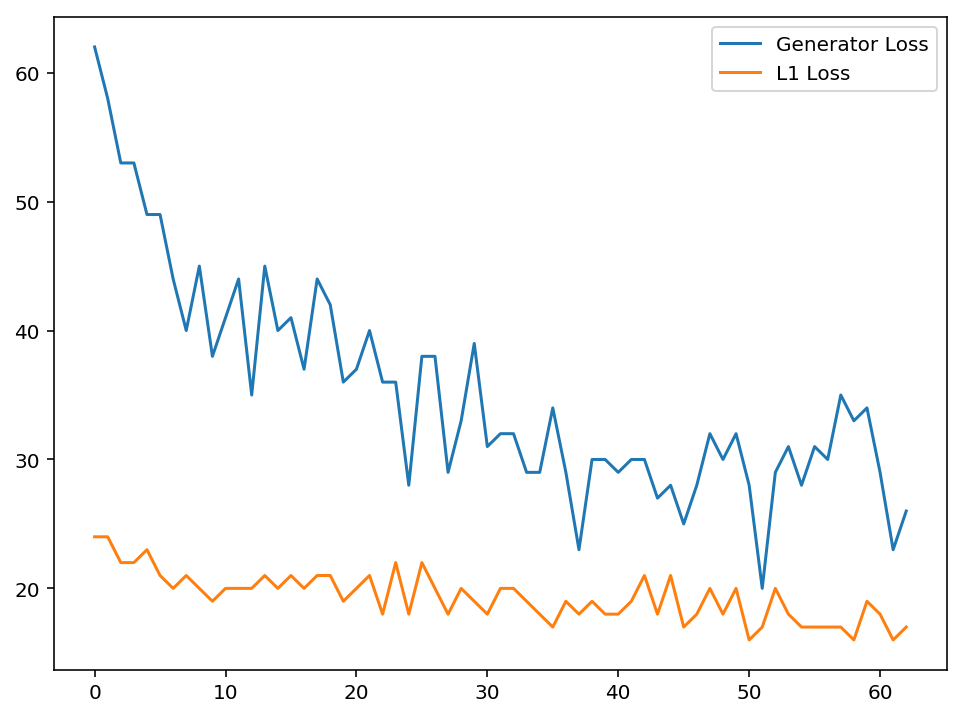

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(g_losses, label='Generator Loss')
plt.plot(l1_losses, label='L1 Loss')
plt.legend()
plt.show()

### Fine Tune - 156~300epoch

In [17]:
save_path = './handwritings/fixed_fake_210chars/new_freeze'
to_model_path = './handwritings/model_checkpoint_210chars/new_freeze'
from_model_path = './handwritings/model_checkpoint_210chars/new_freeze'
restore = ['153-0610-05:13-Encoder.pkl', '153-0610-05:13-Decoder.pkl', '153-0610-05:13-Discriminator.pkl']

max_epoch = 147
schedule = 40
lr = 0.001
log_step = 20
sample_step = 20

losses = trainer.train(max_epoch=max_epoch, schedule=schedule, save_path=save_path, \
                       lr=lr, log_step=log_step, sample_step=sample_step, restore=restore, \
                       to_model_path=to_model_path, from_model_path=from_model_path, \
                       with_charid=True, freeze_encoder=True, fine_tune=True, \
                       save_nrow=6, model_save_step=30)

153 epoch trained model has restored
05:14:24 Epoch [154/300], step [20/21], l1_loss: 58.7239, d_loss: 0.0003, g_loss: 67.8839
05:14:29 Epoch [155/300], step [20/21], l1_loss: 52.9809, d_loss: 0.0000, g_loss: 68.7121
05:14:34 Epoch [156/300], step [20/21], l1_loss: 51.1118, d_loss: 0.0000, g_loss: 69.7663
05:14:40 Epoch [157/300], step [20/21], l1_loss: 60.1235, d_loss: 0.0007, g_loss: 68.0723
05:14:45 Epoch [158/300], step [20/21], l1_loss: 67.5718, d_loss: 0.0010, g_loss: 75.0882
05:14:50 Epoch [159/300], step [20/21], l1_loss: 55.4581, d_loss: 0.0000, g_loss: 81.1855
05:14:55 Epoch [160/300], step [20/21], l1_loss: 52.5807, d_loss: 0.0075, g_loss: 60.1821
05:15:00 Epoch [161/300], step [20/21], l1_loss: 52.3152, d_loss: 0.0000, g_loss: 64.2491
05:15:06 Epoch [162/300], step [20/21], l1_loss: 66.5194, d_loss: 0.4011, g_loss: 68.0940
05:15:11 Epoch [163/300], step [20/21], l1_loss: 59.5000, d_loss: 0.0000, g_loss: 91.6720
05:15:16 Epoch [164/300], step [20/21], l1_loss: 57.5975, d_los

05:22:14 Epoch [244/300], step [20/21], l1_loss: 52.9475, d_loss: 0.0005, g_loss: 63.2353
05:22:19 Epoch [245/300], step [20/21], l1_loss: 52.1480, d_loss: 0.0045, g_loss: 59.8776
05:22:24 Epoch [246/300], step [20/21], l1_loss: 42.1141, d_loss: 0.0117, g_loss: 50.3621
05:22:29 Epoch [247/300], step [20/21], l1_loss: 51.6816, d_loss: 0.0152, g_loss: 57.7327
05:22:35 Epoch [248/300], step [20/21], l1_loss: 43.0431, d_loss: 0.0075, g_loss: 49.1892
05:22:40 Epoch [249/300], step [20/21], l1_loss: 48.3471, d_loss: 0.0076, g_loss: 56.6271
05:22:45 Epoch [250/300], step [20/21], l1_loss: 49.2386, d_loss: 0.0006, g_loss: 59.1282
05:22:50 Epoch [251/300], step [20/21], l1_loss: 43.6204, d_loss: 0.0030, g_loss: 52.3196
05:22:55 Epoch [252/300], step [20/21], l1_loss: 45.4469, d_loss: 0.0252, g_loss: 50.2131
05:23:01 Epoch [253/300], step [20/21], l1_loss: 50.6825, d_loss: 0.1001, g_loss: 63.4935
05:23:06 Epoch [254/300], step [20/21], l1_loss: 45.0862, d_loss: 0.0014, g_loss: 52.3679
05:23:11 E

- 1epoch에 3초 : 100epoch에 300초, 5분

In [18]:
l1_losses, const_losses, category_losses, d_losses, g_losses = losses

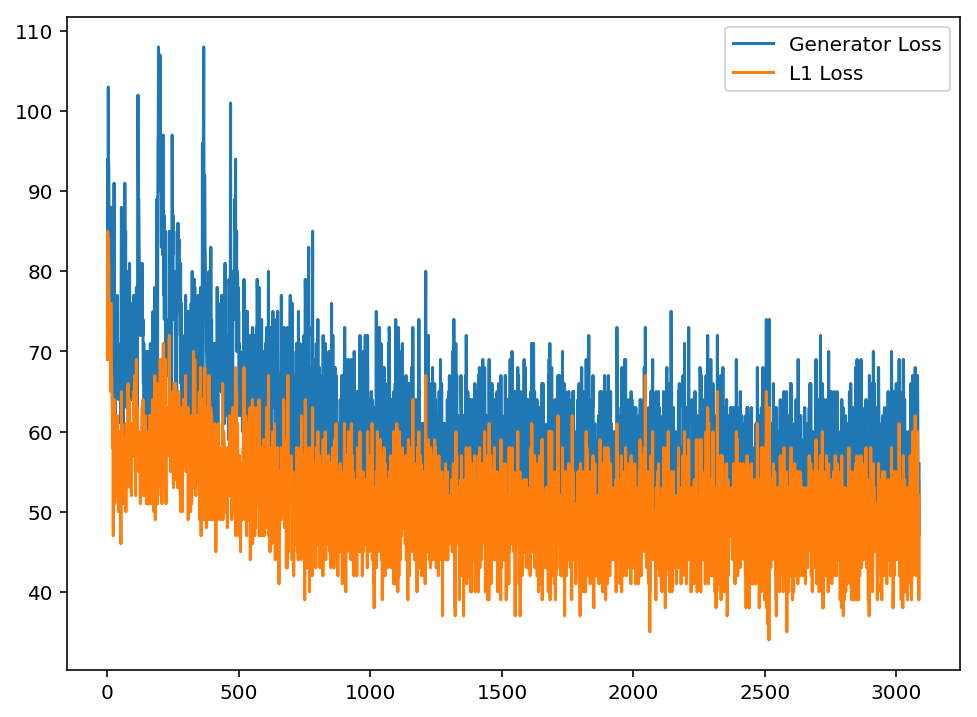

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(g_losses, label='Generator Loss')
plt.plot(l1_losses, label='L1 Loss')
plt.legend()
plt.show()

In [20]:
print('initial loss:', np.mean(g_losses[:500]), '->', 'last loss:', np.mean(g_losses[-500:]))

initial loss: 72.718 -> last loss: 55.626


### 300~500 epoch train
- 100epoch에 5분, 200epoch에 10분

In [9]:
save_path = './handwritings/fixed_fake_210chars/new_freeze'
to_model_path = './handwritings/model_checkpoint_210chars/new_freeze'
from_model_path = './handwritings/model_checkpoint_210chars/new_freeze'
restore = ['300-0610-05:27-Encoder.pkl', '300-0610-05:27-Decoder.pkl', '300-0610-05:27-Discriminator.pkl']

max_epoch = 200
schedule = 40
lr = 0.0002
log_step = 20
sample_step = 20

losses = trainer.train(max_epoch=max_epoch, schedule=schedule, save_path=save_path, \
                       lr=lr, log_step=log_step, sample_step=sample_step, restore=restore, \
                       to_model_path=to_model_path, from_model_path=from_model_path, \
                       with_charid=True, freeze_encoder=True, fine_tune=True, \
                       save_nrow=6, model_save_step=30, flip_labels=True)

300 epoch trained model has restored
05:48:31 Epoch [301/500], step [20/22], l1_loss: 48.0234, d_loss: 0.0046, g_loss: 58.9210
05:48:34 Epoch [302/500], step [20/22], l1_loss: 56.9814, d_loss: 0.0055, g_loss: 64.6903
05:48:36 Epoch [303/500], step [20/22], l1_loss: 57.4863, d_loss: 0.0000, g_loss: 71.5571
05:48:39 Epoch [304/500], step [20/22], l1_loss: 58.8617, d_loss: 0.0050, g_loss: 67.0163
05:48:42 Epoch [305/500], step [20/22], l1_loss: 55.5432, d_loss: 0.0013, g_loss: 63.0014
05:48:45 Epoch [306/500], step [20/22], l1_loss: 49.8587, d_loss: 0.0050, g_loss: 59.6367
05:48:48 Epoch [307/500], step [20/22], l1_loss: 50.9792, d_loss: 0.0175, g_loss: 64.2189
05:48:50 Epoch [308/500], step [20/22], l1_loss: 53.8177, d_loss: 0.0050, g_loss: 70.2704
05:48:53 Epoch [309/500], step [20/22], l1_loss: 42.3708, d_loss: 0.0088, g_loss: 50.2703
05:48:56 Epoch [310/500], step [20/22], l1_loss: 45.4045, d_loss: 0.0008, g_loss: 55.6017
05:48:59 Epoch [311/500], step [20/22], l1_loss: 56.9886, d_los

05:52:50 Epoch [392/500], step [20/22], l1_loss: 43.2231, d_loss: 0.0014, g_loss: 50.6930
05:52:53 Epoch [393/500], step [20/22], l1_loss: 43.7113, d_loss: 0.0001, g_loss: 54.9006
05:52:56 Epoch [394/500], step [20/22], l1_loss: 45.9907, d_loss: 0.0012, g_loss: 56.3178
05:52:59 Epoch [395/500], step [20/22], l1_loss: 49.8808, d_loss: 0.0361, g_loss: 53.9121
05:53:02 Epoch [396/500], step [20/22], l1_loss: 45.2485, d_loss: 0.0145, g_loss: 51.2552
05:53:04 Epoch [397/500], step [20/22], l1_loss: 50.8871, d_loss: 0.0053, g_loss: 57.9531
05:53:07 Epoch [398/500], step [20/22], l1_loss: 43.5099, d_loss: 0.0015, g_loss: 52.7426
05:53:10 Epoch [399/500], step [20/22], l1_loss: 43.3115, d_loss: 0.1370, g_loss: 50.6614
05:53:13 Epoch [400/500], step [20/22], l1_loss: 41.5894, d_loss: 0.0131, g_loss: 53.3708
05:53:16 Epoch [401/500], step [20/22], l1_loss: 57.0113, d_loss: 0.0011, g_loss: 64.7105
05:53:19 Epoch [402/500], step [20/22], l1_loss: 44.8764, d_loss: 0.0314, g_loss: 49.8403
05:53:22 E

05:57:11 Epoch [484/500], step [20/22], l1_loss: 49.2116, d_loss: 0.0001, g_loss: 61.2049
05:57:14 Epoch [485/500], step [20/22], l1_loss: 49.1063, d_loss: 0.0209, g_loss: 54.5497
05:57:17 Epoch [486/500], step [20/22], l1_loss: 44.2004, d_loss: 0.0348, g_loss: 48.6078
05:57:20 Epoch [487/500], step [20/22], l1_loss: 40.9734, d_loss: 0.0223, g_loss: 45.4384
05:57:23 Epoch [488/500], step [20/22], l1_loss: 48.0921, d_loss: 0.0195, g_loss: 53.9056
05:57:25 Epoch [489/500], step [20/22], l1_loss: 46.6282, d_loss: 0.0020, g_loss: 54.3629
05:57:28 Epoch [490/500], step [20/22], l1_loss: 44.6337, d_loss: 0.0065, g_loss: 50.9916
05:57:31 Epoch [491/500], step [20/22], l1_loss: 47.4610, d_loss: 0.0004, g_loss: 57.5634
05:57:34 Epoch [492/500], step [20/22], l1_loss: 45.9094, d_loss: 0.0018, g_loss: 53.6043
05:57:37 Epoch [493/500], step [20/22], l1_loss: 40.6979, d_loss: 0.0087, g_loss: 50.4679
05:57:40 Epoch [494/500], step [20/22], l1_loss: 42.9205, d_loss: 0.0004, g_loss: 52.5877
05:57:42 E

In [10]:
l1_losses, const_losses, category_losses, d_losses, g_losses = losses

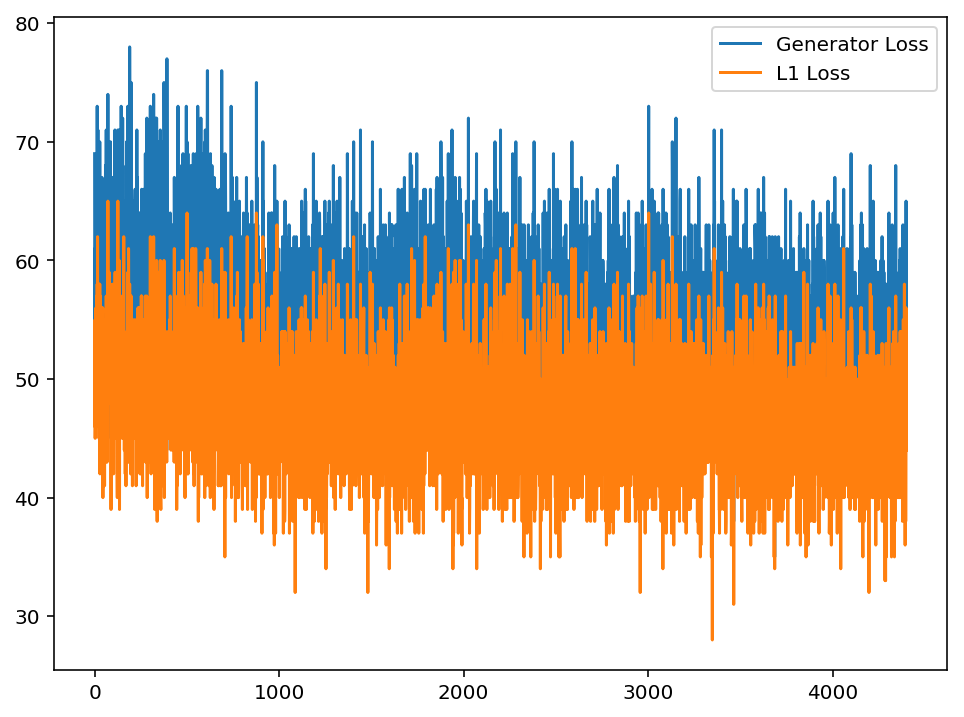

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(g_losses, label='Generator Loss')
plt.plot(l1_losses, label='L1 Loss')
plt.legend()
plt.show()

In [12]:
print('initial loss:', np.mean(g_losses[:500]), '->', 'last loss:', np.mean(g_losses[-500:]))

initial loss: 59.534 -> last loss: 53.134


### 500~1000 epoch

In [13]:
save_path = './handwritings/fixed_fake_210chars/new_freeze'
to_model_path = './handwritings/model_checkpoint_210chars/new_freeze'
from_model_path = './handwritings/model_checkpoint_210chars/new_freeze'
restore = ['500-0611-05:57-Encoder.pkl', '500-0611-05:57-Decoder.pkl', '500-0611-05:57-Discriminator.pkl']

max_epoch = 500
schedule = 40
lr = 0.0002
log_step = 20
sample_step = 20

losses = trainer.train(max_epoch=max_epoch, schedule=schedule, save_path=save_path, \
                       lr=lr, log_step=log_step, sample_step=sample_step, restore=restore, \
                       to_model_path=to_model_path, from_model_path=from_model_path, \
                       with_charid=True, freeze_encoder=True, fine_tune=True, \
                       save_nrow=6, model_save_step=30, flip_labels=True)

500 epoch trained model has restored
06:05:03 Epoch [501/1000], step [20/22], l1_loss: 44.3413, d_loss: 0.0149, g_loss: 55.6185
06:05:08 Epoch [502/1000], step [20/22], l1_loss: 50.9701, d_loss: 0.0064, g_loss: 58.0277
06:05:14 Epoch [503/1000], step [20/22], l1_loss: 45.0714, d_loss: 0.0204, g_loss: 56.4150
06:05:19 Epoch [504/1000], step [20/22], l1_loss: 44.7101, d_loss: 0.0003, g_loss: 56.3656
06:05:25 Epoch [505/1000], step [20/22], l1_loss: 36.0518, d_loss: 0.1688, g_loss: 44.2371
06:05:30 Epoch [506/1000], step [20/22], l1_loss: 45.6180, d_loss: 0.0348, g_loss: 51.6341
06:05:36 Epoch [507/1000], step [20/22], l1_loss: 52.1197, d_loss: 0.0016, g_loss: 65.9785
06:05:41 Epoch [508/1000], step [20/22], l1_loss: 45.2029, d_loss: 0.0167, g_loss: 52.2185
06:05:47 Epoch [509/1000], step [20/22], l1_loss: 47.2175, d_loss: 0.1441, g_loss: 52.0868
06:05:52 Epoch [510/1000], step [20/22], l1_loss: 41.5923, d_loss: 0.0267, g_loss: 52.4103
06:05:58 Epoch [511/1000], step [20/22], l1_loss: 46.

06:13:19 Epoch [591/1000], step [20/22], l1_loss: 46.1260, d_loss: 0.0065, g_loss: 56.0584
06:13:24 Epoch [592/1000], step [20/22], l1_loss: 39.7487, d_loss: 0.0240, g_loss: 44.4892
06:13:30 Epoch [593/1000], step [20/22], l1_loss: 40.1569, d_loss: 0.0247, g_loss: 49.9778
06:13:35 Epoch [594/1000], step [20/22], l1_loss: 34.9734, d_loss: 0.0240, g_loss: 42.8580
06:13:41 Epoch [595/1000], step [20/22], l1_loss: 50.2069, d_loss: 0.0254, g_loss: 54.4793
06:13:46 Epoch [596/1000], step [20/22], l1_loss: 44.1286, d_loss: 0.3706, g_loss: 46.3718
06:13:52 Epoch [597/1000], step [20/22], l1_loss: 44.4550, d_loss: 0.0150, g_loss: 51.7489
06:13:57 Epoch [598/1000], step [20/22], l1_loss: 42.6642, d_loss: 0.2367, g_loss: 45.5384
06:14:03 Epoch [599/1000], step [20/22], l1_loss: 48.2320, d_loss: 0.0156, g_loss: 53.6304
06:14:08 Epoch [600/1000], step [20/22], l1_loss: 43.8327, d_loss: 0.0236, g_loss: 54.4755
06:14:14 Epoch [601/1000], step [20/22], l1_loss: 34.8850, d_loss: 0.1032, g_loss: 48.4823

06:21:39 Epoch [682/1000], step [20/22], l1_loss: 37.2759, d_loss: 0.0536, g_loss: 44.1560
06:21:45 Epoch [683/1000], step [20/22], l1_loss: 32.4782, d_loss: 0.0301, g_loss: 39.0130
06:21:50 Epoch [684/1000], step [20/22], l1_loss: 35.5854, d_loss: 0.0311, g_loss: 41.7436
06:21:56 Epoch [685/1000], step [20/22], l1_loss: 43.6999, d_loss: 0.0088, g_loss: 53.3718
06:22:01 Epoch [686/1000], step [20/22], l1_loss: 31.7531, d_loss: 0.0370, g_loss: 37.0806
06:22:07 Epoch [687/1000], step [20/22], l1_loss: 33.7877, d_loss: 0.0419, g_loss: 40.5410
06:22:12 Epoch [688/1000], step [20/22], l1_loss: 41.7172, d_loss: 0.0366, g_loss: 48.8387
06:22:18 Epoch [689/1000], step [20/22], l1_loss: 47.7982, d_loss: 0.0139, g_loss: 53.5479
06:22:23 Epoch [690/1000], step [20/22], l1_loss: 40.7111, d_loss: 0.0051, g_loss: 47.3298
06:22:29 Epoch [691/1000], step [20/22], l1_loss: 38.6280, d_loss: 0.0673, g_loss: 42.9557
06:22:34 Epoch [692/1000], step [20/22], l1_loss: 44.2058, d_loss: 0.0227, g_loss: 49.0217

06:30:00 Epoch [773/1000], step [20/22], l1_loss: 42.3121, d_loss: 0.0821, g_loss: 45.7595
06:30:06 Epoch [774/1000], step [20/22], l1_loss: 42.3269, d_loss: 0.0432, g_loss: 48.9290
06:30:11 Epoch [775/1000], step [20/22], l1_loss: 48.4430, d_loss: 0.0013, g_loss: 57.5028
06:30:16 Epoch [776/1000], step [20/22], l1_loss: 43.8334, d_loss: 0.0209, g_loss: 52.3988
06:30:22 Epoch [777/1000], step [20/22], l1_loss: 45.5054, d_loss: 0.0028, g_loss: 53.2179
06:30:28 Epoch [778/1000], step [20/22], l1_loss: 43.3922, d_loss: 0.1976, g_loss: 45.6610
06:30:33 Epoch [779/1000], step [20/22], l1_loss: 41.4082, d_loss: 0.0223, g_loss: 46.8913
06:30:38 Epoch [780/1000], step [20/22], l1_loss: 46.3319, d_loss: 0.0004, g_loss: 57.2305
06:30:44 Epoch [781/1000], step [20/22], l1_loss: 47.4945, d_loss: 0.0050, g_loss: 53.8362
06:30:49 Epoch [782/1000], step [20/22], l1_loss: 41.3309, d_loss: 0.0013, g_loss: 49.6777
06:30:55 Epoch [783/1000], step [20/22], l1_loss: 37.2309, d_loss: 0.0063, g_loss: 46.0396

06:38:20 Epoch [864/1000], step [20/22], l1_loss: 37.4784, d_loss: 0.0009, g_loss: 46.6187
06:38:26 Epoch [865/1000], step [20/22], l1_loss: 41.7874, d_loss: 0.0044, g_loss: 49.3726
06:38:31 Epoch [866/1000], step [20/22], l1_loss: 40.2966, d_loss: 0.0071, g_loss: 46.4360
06:38:37 Epoch [867/1000], step [20/22], l1_loss: 50.7841, d_loss: 0.0153, g_loss: 58.5763
06:38:42 Epoch [868/1000], step [20/22], l1_loss: 52.5594, d_loss: 0.0053, g_loss: 59.7482
06:38:48 Epoch [869/1000], step [20/22], l1_loss: 38.1279, d_loss: 0.0073, g_loss: 46.5383
06:38:53 Epoch [870/1000], step [20/22], l1_loss: 39.5957, d_loss: 0.0506, g_loss: 51.4626
06:38:59 Epoch [871/1000], step [20/22], l1_loss: 44.8948, d_loss: 0.0022, g_loss: 53.1999
06:39:04 Epoch [872/1000], step [20/22], l1_loss: 36.7307, d_loss: 0.0925, g_loss: 43.0062
06:39:10 Epoch [873/1000], step [20/22], l1_loss: 47.7545, d_loss: 0.0012, g_loss: 56.1197
06:39:15 Epoch [874/1000], step [20/22], l1_loss: 42.5306, d_loss: 0.0118, g_loss: 52.1458

06:46:40 Epoch [955/1000], step [20/22], l1_loss: 40.5676, d_loss: 0.0017, g_loss: 49.7562
06:46:45 Epoch [956/1000], step [20/22], l1_loss: 41.3205, d_loss: 0.0350, g_loss: 46.7954
06:46:51 Epoch [957/1000], step [20/22], l1_loss: 36.4250, d_loss: 0.0155, g_loss: 42.3041
06:46:56 Epoch [958/1000], step [20/22], l1_loss: 41.9280, d_loss: 0.2638, g_loss: 44.2282
06:47:02 Epoch [959/1000], step [20/22], l1_loss: 46.9340, d_loss: 0.0014, g_loss: 57.4531
06:47:07 Epoch [960/1000], step [20/22], l1_loss: 38.5170, d_loss: 0.0264, g_loss: 44.9582
06:47:13 Epoch [961/1000], step [20/22], l1_loss: 43.5248, d_loss: 0.0314, g_loss: 49.5551
06:47:18 Epoch [962/1000], step [20/22], l1_loss: 47.8993, d_loss: 0.0005, g_loss: 58.1680
06:47:24 Epoch [963/1000], step [20/22], l1_loss: 46.3587, d_loss: 0.0181, g_loss: 51.7307
06:47:29 Epoch [964/1000], step [20/22], l1_loss: 43.8170, d_loss: 0.0545, g_loss: 47.6080
06:47:35 Epoch [965/1000], step [20/22], l1_loss: 42.7487, d_loss: 0.1455, g_loss: 48.9699

In [14]:
l1_losses, const_losses, category_losses, d_losses, g_losses = losses

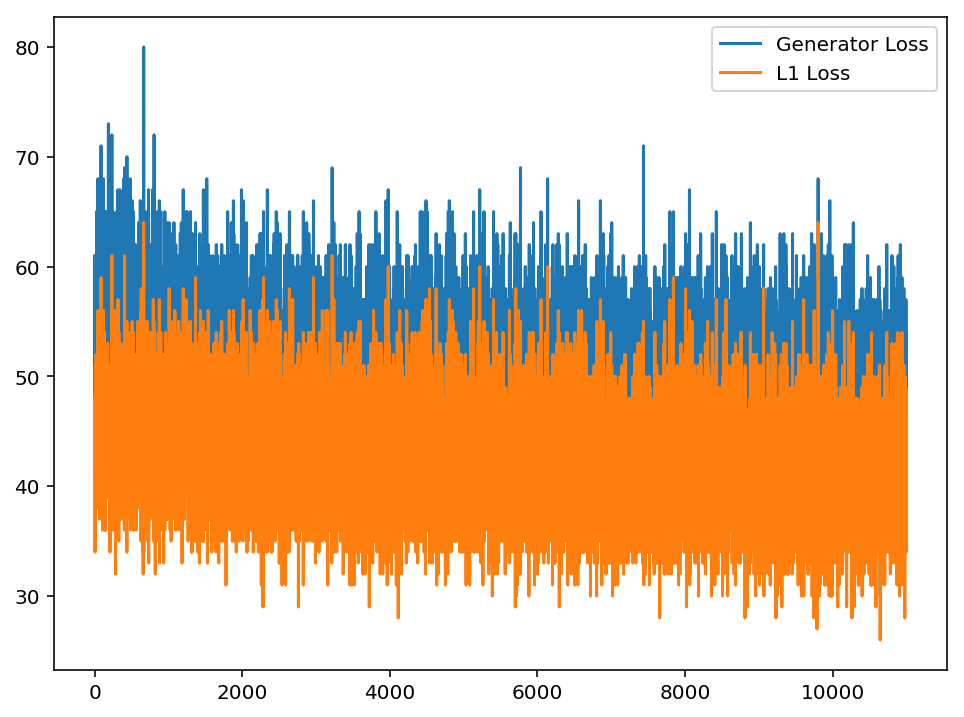

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(g_losses, label='Generator Loss')
plt.plot(l1_losses, label='L1 Loss')
plt.legend()
plt.show()

In [16]:
print('initial loss:', np.mean(g_losses[:500]), '->', 'last loss:', np.mean(g_losses[-500:]))

initial loss: 54.112 -> last loss: 47.662


- WOW

---

### save GIF

In [62]:
image_path = './handwritings/fixed_fake_210chars/new_freeze'
filenames = sorted(glob.glob(os.path.join(image_path, "*.png")))[1:]
filenames = [filenames[idx] for idx in range(30) if idx % 3] + \
            [filenames[idx] for idx in range(31, len(filenames)-300) if ((idx+1) % 30) == 0]
print(len(filenames))
filenames[-10:]

37


['./handwritings/fixed_fake_210chars/new_freeze/fake_samples-420-20.png',
 './handwritings/fixed_fake_210chars/new_freeze/fake_samples-450-20.png',
 './handwritings/fixed_fake_210chars/new_freeze/fake_samples-480-20.png',
 './handwritings/fixed_fake_210chars/new_freeze/fake_samples-510-20.png',
 './handwritings/fixed_fake_210chars/new_freeze/fake_samples-540-20.png',
 './handwritings/fixed_fake_210chars/new_freeze/fake_samples-570-20.png',
 './handwritings/fixed_fake_210chars/new_freeze/fake_samples-600-20.png',
 './handwritings/fixed_fake_210chars/new_freeze/fake_samples-630-20.png',
 './handwritings/fixed_fake_210chars/new_freeze/fake_samples-660-20.png',
 './handwritings/fixed_fake_210chars/new_freeze/fake_samples-690-20.png']

In [63]:
gif_path = './handwritings/gifz'
image_path = './handwritings/fixed_fake_210chars/'
file_name = 'handwriting_test_training_new_freeze.gif'

images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave(os.path.join(gif_path, file_name), images)

### 최종결과

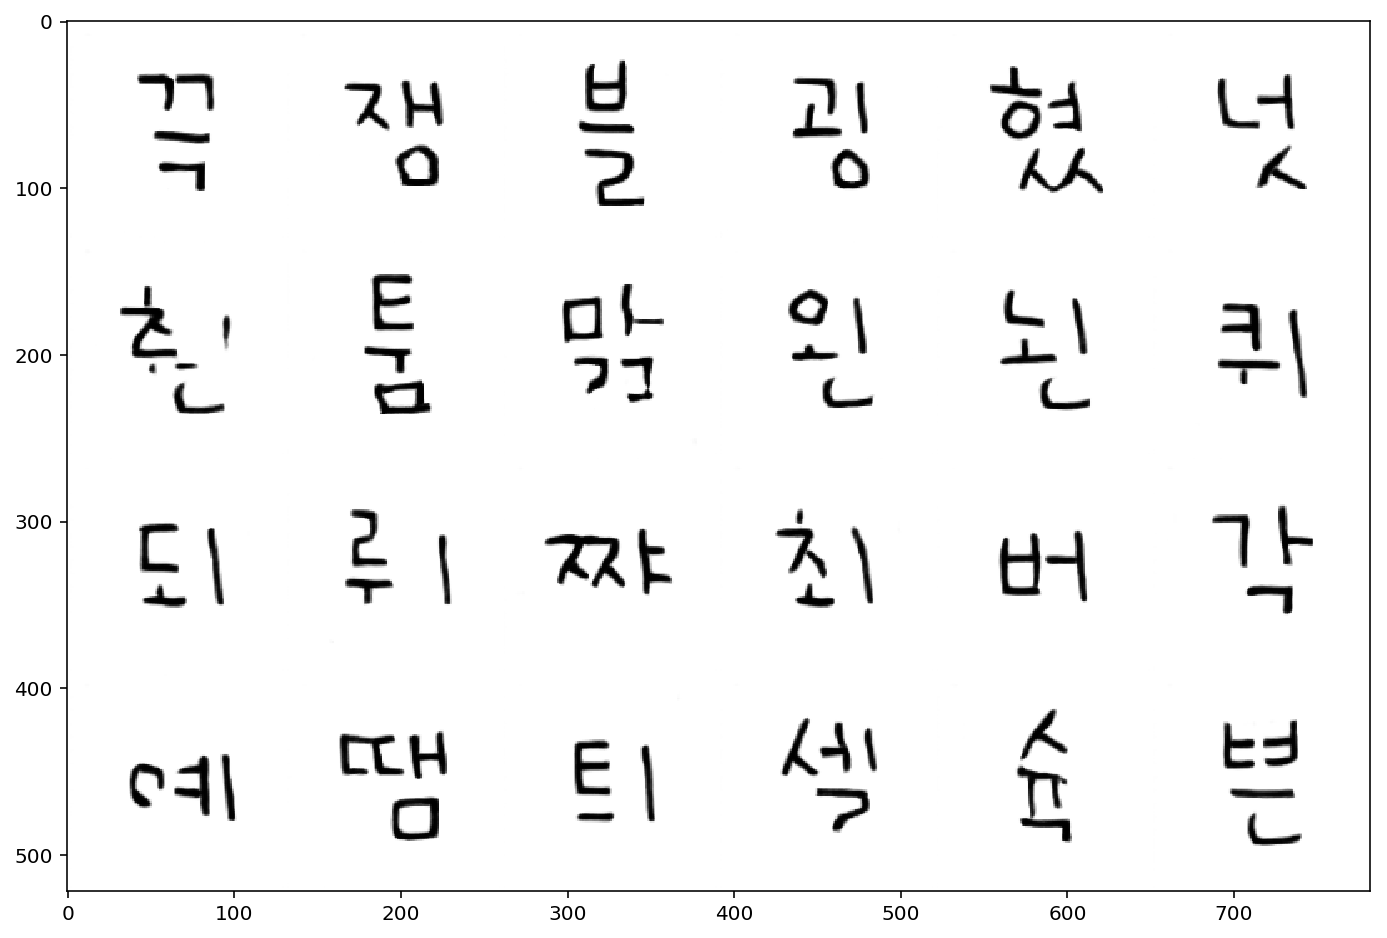

In [71]:
file = filenames[-1]
a = Image.open(file).convert('L')
plt.figure(figsize=(12, 8))
plt.imshow(a, cmap='gray')
plt.show()

- old freeze한테 짐

---

# Validation
- 안 본 글자들도 생성해보기

### Model import

In [72]:
from_model_path = './handwritings/model_checkpoint_210chars/new_freeze'
fixed_dir = './handwritings/fixed_sample/'

In [73]:
embeddings = torch.load(os.path.join(fixed_dir, 'EMBEDDINGS.pkl'))
embeddings.shape

torch.Size([100, 1, 1, 128])

In [76]:
fixed_label = torch.load(os.path.join(fixed_dir, 'fixed_label_0.pkl'))
fixed_target = torch.load(os.path.join(fixed_dir, 'fixed_target_0.pkl'))
fixed_source = torch.load(os.path.join(fixed_dir, 'fixed_source_0.pkl'))

In [74]:
En = Encoder().cuda()
De = Decoder().cuda()
D = Discriminator(category_num=25).cuda()

restore = ['1000-0611-06:50-Encoder.pkl', '1000-0611-06:50-Decoder.pkl', '1000-0611-06:50-Discriminator.pkl']

encoder_path, decoder_path, discriminator_path = restore
prev_epoch = int(encoder_path.split('-')[0])
En.load_state_dict(torch.load(os.path.join(from_model_path, encoder_path)))
De.load_state_dict(torch.load(os.path.join(from_model_path, decoder_path)))
D.load_state_dict(torch.load(os.path.join(from_model_path, discriminator_path)))
print("%d epoch trained model has restored" % prev_epoch)

1000 epoch trained model has restored


### show

In [77]:
fake_target, encoded_source, _ = Generator(fixed_source, En, De, embeddings, \
                                           fixed_label, GPU=GPU, encode_layers=True)

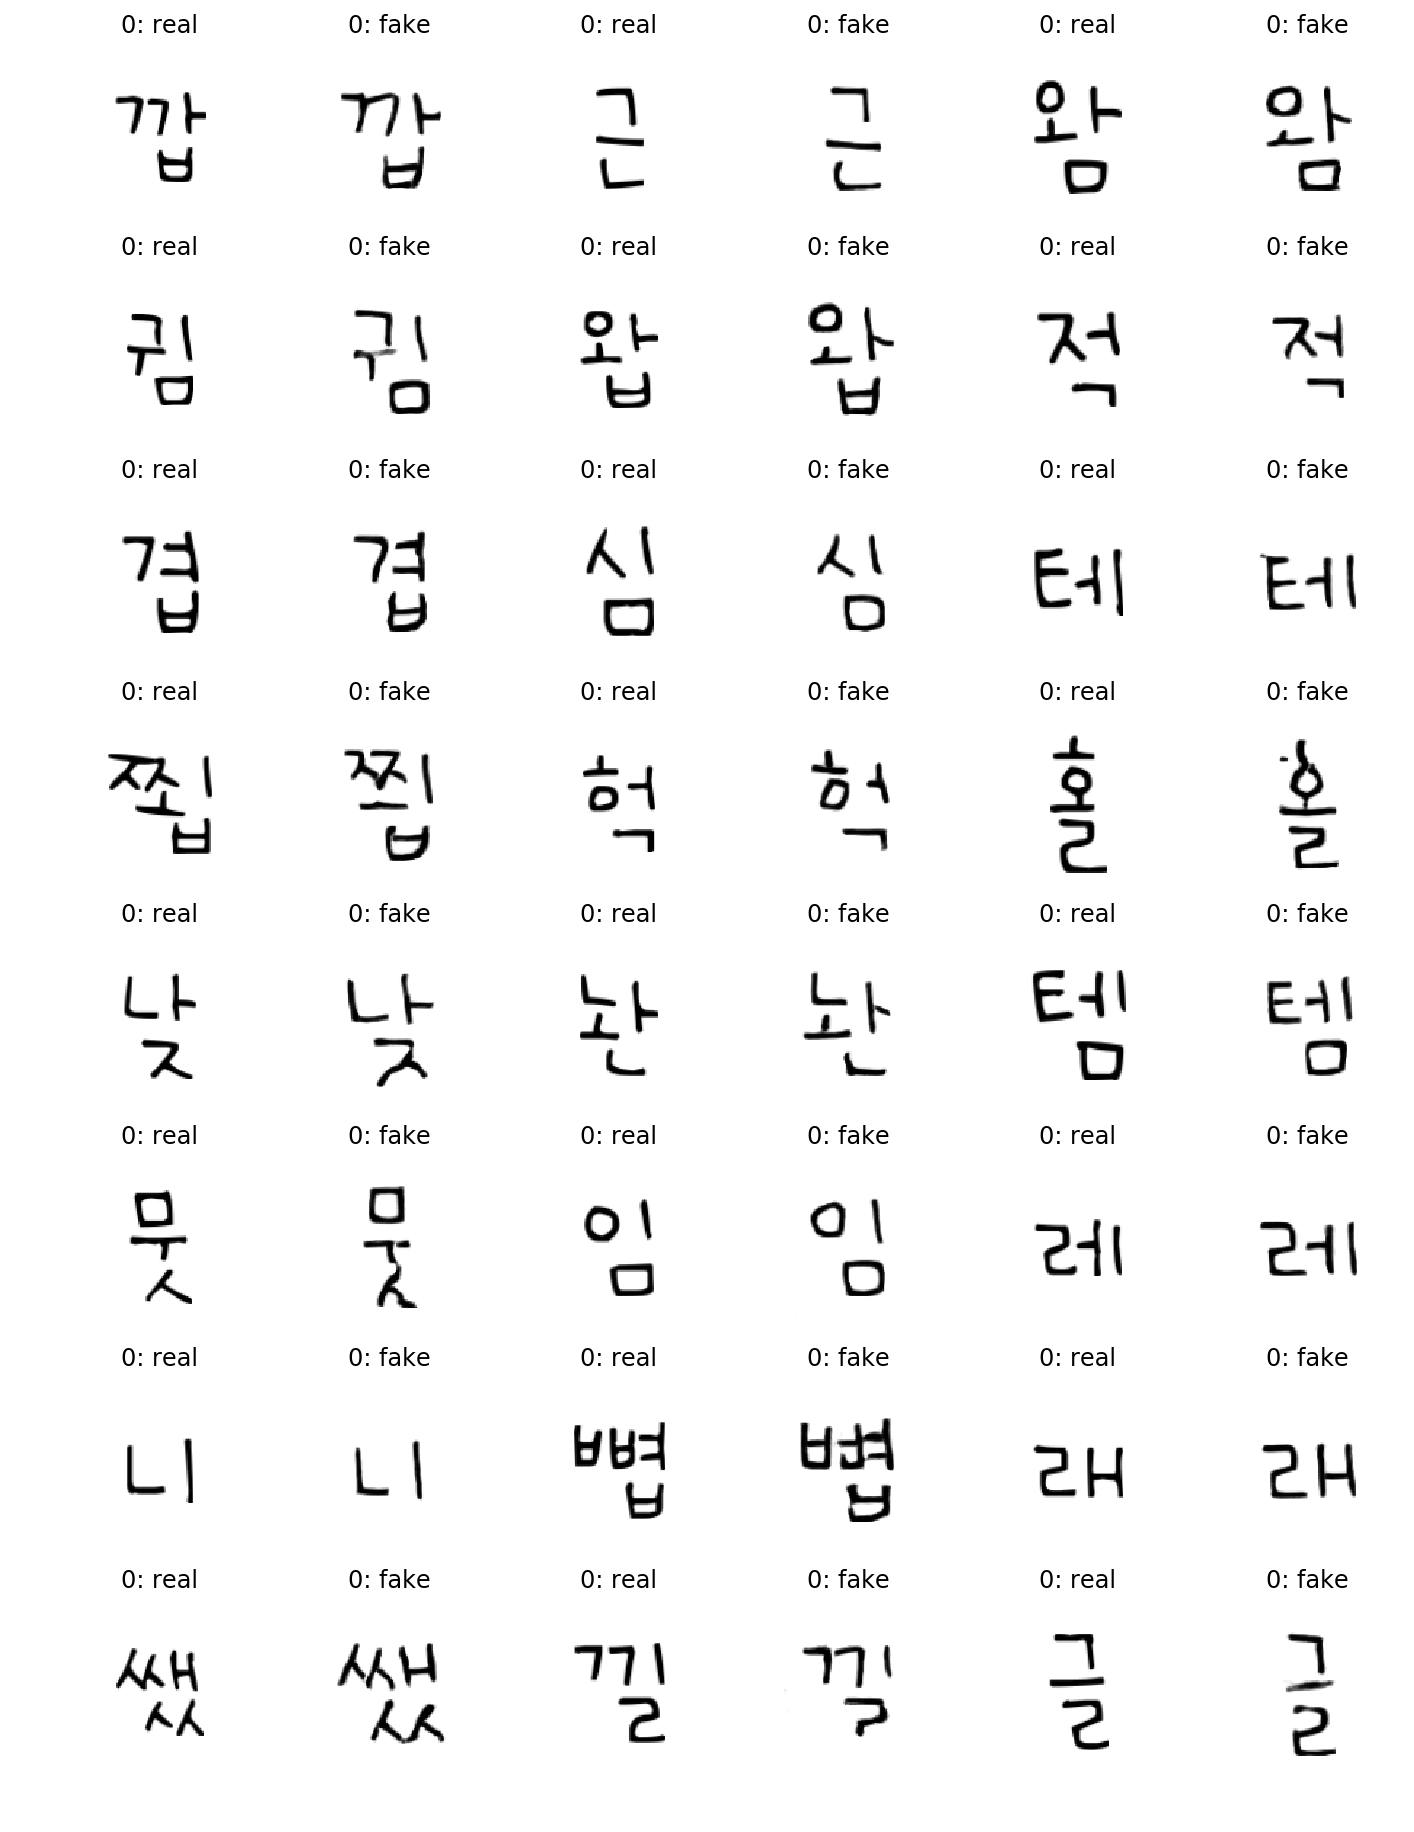

In [79]:
plt.figure(figsize=(12, 16))
for idx, (image_R, image_F) in enumerate(zip(fixed_target, fake_target)):
    plt.subplot(8, 6, 2*idx+1)
    plt.imshow(image_R.cpu().detach().numpy().reshape(128, 128), cmap='gray')
    plt.title(str(int(fixed_label[idx].data)) + ': real')
    plt.axis('off')
    
    plt.subplot(8, 6, 2*idx+2)
    plt.imshow(image_F.cpu().detach().numpy().reshape(128, 128), cmap='gray')
    plt.title(str(int(fixed_label[idx].data)) + ': fake')
    plt.axis('off')
plt.show()

---